You can run this notebook in a [live session](https://mybinder.org/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/decadal/diagnose-potential-predictability.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://mybinder.org/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/decadal/diagnose-potential-predictability.ipynb) or view it [on Github](https://github.com/pangeo-data/climpred/blob/main/docs/source/examples/decadal/diagnose-potential-predictability.ipynb).

# Diagnosing Potential Predictability

This demo demonstrates `climpred`'s capabilities to diagnose areas containing potentially predictable variations from a ``control``/``verification`` alone without requiring multi-member, multi-initialization simulations. This notebook identifies the slow components of internal variability that indicate potential predictability. Here, we showcase a set of methods to show regions indicating probabilities for decadal predictability.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import climpred

<IPython.core.display.Javascript object>

In [3]:
# Sea surface temperature
varname = "tos"
control3d = climpred.tutorial.load_dataset("MPI-control-3D")[varname].load()

<IPython.core.display.Javascript object>

## Diagnostic Potential Predictability (DPP)

We can first use the {cite:t}`Resplandy2015` and {cite:t}`Seferian2018` method for computing the unbiased {py:func}`.climpred.stats.dpp` by not chunking the time dimension.

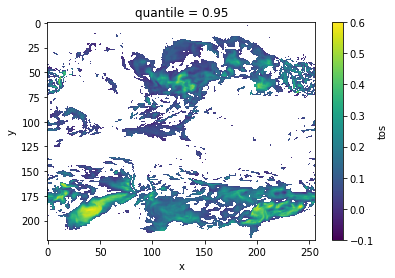

<IPython.core.display.Javascript object>

In [4]:
# calculate DPP with m=10
DPP10 = climpred.stats.dpp(control3d, m=10, chunk=False)
# calculate a threshold by random shuffling (based on bootstrapping with replacement at 95% significance level)
threshold = climpred.bootstrap.dpp_threshold(
    control3d, m=10, chunk=False, iterations=10, sig=95
)
# plot grid cells where DPP above threshold
DPP10.where(DPP10 > threshold).plot(
    yincrease=False, vmin=-0.1, vmax=0.6, cmap="viridis"
)

Now, we can turn on ``chunking`` (default) to use the {cite:t}`Boer2004` method. 

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


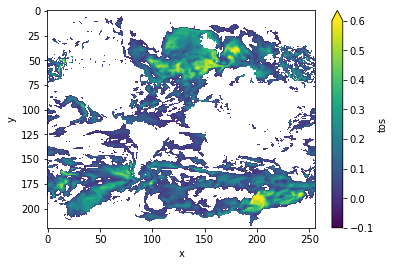

<IPython.core.display.Javascript object>

In [5]:
# chunk = True signals the Boer 2004 method
DPP10 = climpred.stats.dpp(control3d, m=10, chunk=True)
threshold = climpred.bootstrap.dpp_threshold(
    control3d, m=10, chunk=True, iterations=10, sig=95
)
DPP10.where(DPP10 > 0).plot(yincrease=False, vmin=-0.1, vmax=0.6, cmap="viridis")

## Variance-Weighted Mean Period

{py:func}`.climpred.stats.varweighted_mean_period` uses a periodogram based on a control simulation to extract the mean period of variations, which are weighted by the respective variance. Regions with a high mean period value indicate low-frequency variations with are potentially predictable {cite:p}`Branstator2010`.

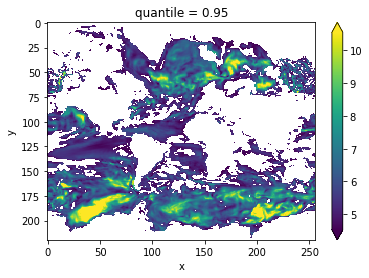

<IPython.core.display.Javascript object>

In [6]:
vwmp = climpred.stats.varweighted_mean_period(control3d, dim="time")
threshold = climpred.bootstrap.varweighted_mean_period_threshold(
    control3d, iterations=10
)
vwmp.where(vwmp > threshold).plot(yincrease=False, robust=True)

## Lag-1 Autocorrelation

The lag-1 autocorrelation also indicates where slower modes of variability occur by identifying regions with high temporal correlation {cite:p}`Storch1999`.

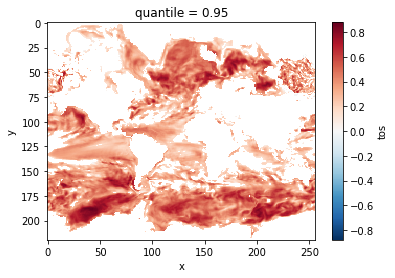

<IPython.core.display.Javascript object>

In [7]:
from esmtools.stats import autocorr

# use climpred.bootstrap._bootstrap_func to wrap any stats function. `esmtools.stats.autocorr` computes the autocorrelation
# coefficient out to N lags. The first lag is at lag 0, so we select `lead=1`).
threshold = climpred.bootstrap._bootstrap_func(
    autocorr, control3d, nlags=2, resample_dim="time", iterations=10
).isel(lead=1)
corr_ef = autocorr(control3d, nlags=2, dim="time").isel(lead=1)
corr_ef.where(corr_ef > threshold).plot(yincrease=False, robust=False)

## Decorrelation time

Taking the lagged correlation further over all lags, {py:func}`.climpred.stats.decorrelation_time` shows the time after which the autocorrelation fell beyond its e-folding {cite:p}`Storch1999`.

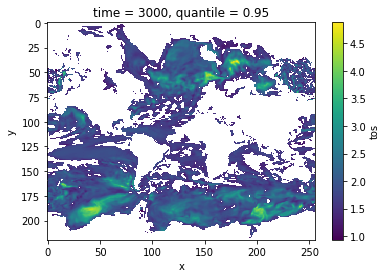

<IPython.core.display.Javascript object>

In [8]:
threshold = climpred.bootstrap._bootstrap_func(
    climpred.stats.decorrelation_time, control3d, "time", iterations=10
)
decorr_time = climpred.stats.decorrelation_time(control3d)
decorr_time.where(decorr_time > threshold).plot(yincrease=False, robust=False)

## Verify diagnostic potential predictability in initialized simulations

Do we find predictability in the areas highlighted above also in perfect-model experiments?

In [9]:
ds3d = climpred.tutorial.load_dataset("MPI-PM-DP-3D")[varname]
control3d = climpred.tutorial.load_dataset("MPI-control-3D")[varname]
ds3d["lead"].attrs["units"] = "years"

pm = climpred.PerfectModelEnsemble(ds3d).add_control(control3d)

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


<IPython.core.display.Javascript object>

In [10]:
bootstrap_skill = pm.bootstrap(
    metric="rmse",
    comparison="m2e",
    dim=["init", "member"],
    reference=["uninitialized"],
    iterations=10,
)

/Users/aaron.spring/Coding/climpred/climpred/checks.py:229: UserWarning: Consider chunking input `ds` along other dimensions than needed by algorithm, e.g. spatial dimensions, for parallelized performance increase.
  warnings.warn(


<IPython.core.display.Javascript object>

In [11]:
init_skill = bootstrap_skill.sel(results="verify skill", skill="initialized")
# p value: probability that random uninitialized forecasts perform better than initialized
p = bootstrap_skill.sel(results="p", skill="uninitialized")

<IPython.core.display.Javascript object>

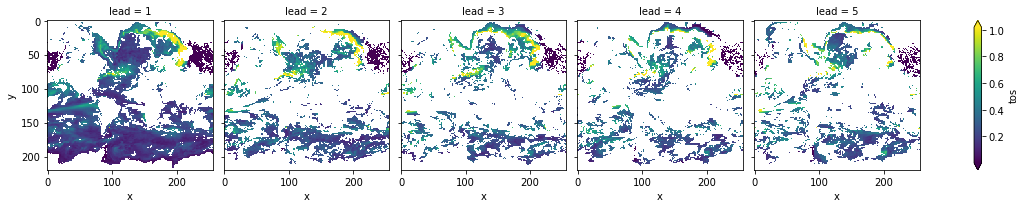

<IPython.core.display.Javascript object>

In [12]:
init_skill.where(p <= 0.05)[varname].plot(
    col="lead", robust=True, yincrease=False, x="x"
)

The metric {py:class}`.climpred.metrics.__rmse` is negatively oriented, e.g. higher values show large disprepancy between members and hence less skill. 

As suggested by {py:func}`.climpred.stats.dpp`, {py:func}`.climpred.stats.varweighted_mean_period` and {py:func}`.climpred.stats.decorrelation_time`, there is predictability in the North Atlantic, North Pacific and Southern Ocean in sea-surface temperatures in slight perturbed `initialized` ensembles .

## References

```{eval-rst}
.. bibliography::
   :filter: docname in docnames
```